In [1]:
import sys
sys.path.append('../')
import importlib

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import seaborn as sbn
from contextlib import redirect_stdout
import json
import ast

import Reinforce as rln
import DataGeneration as dgen
import Classifier as clf
import TuningCurves as tun
import SL_MONKEYtask as sln_mky

/home/martina/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Supervised Learning

In [2]:
#size = "big"
size = "small"
#size = "small_shuffled"
#size = "small_supervised"
#size = "special"

with open(size+'_dataset.json', 'r') as json_file:
    data = json.load(json_file)

frates_actor = np.array(data["frates_actor"])
frates_critic = np.array(data["frates_critic"])
final_actions = np.array(data["final_actions"])
right_values = np.array(data["right_values"])
left_values = np.array(data["left_values"])
overall_values = np.array(data["overall_values"])
global_values = np.array(data["global_values"])
stimuli = np.array(data["stimuli"])
timeav_values = np.array(data["timeav_values"])

In [10]:
net = {"X" : frates_actor, "network" : "ACTOR"}
#net = {"X" : frates_critic, "network" : "CRITIC"}

#label = {"Y" : final_actions, "label" : "ACTIONS"}
#label = {"Y" : right_values, "label" : "RIGHT VALUES"}
#label = {"Y" : left_values, "label" : "LEFT VALUES"}
label = {"Y" : global_values, "label" : "GLOBAL VALUES"}

#model = {"model" : 'perceptron', "param" : 0}
model = {"model" : 'perceptronL1', "param" : 0.01}
#model = {"model" : 'svm', "param" : 0.00001}

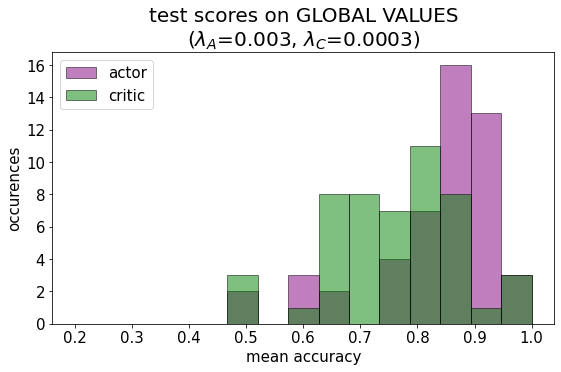

In [11]:
importlib.reload(clf)

param_mag = np.array([3e-3, 3e-4])

clf.actor_vs_critic(frates_actor, frates_critic, Y=label["Y"], model=model["model"],
                    param_mag=param_mag, label=label["label"], noise_mag=0, size=size)

In [18]:
importlib.reload(clf)

clf.rel_neurons(X=net["X"], Y=label["Y"], model=model["model"], C=1e-2,\
               network=net["network"], label=label["label"], noise_mag=0, size=size)

if net["network"] == "actor":
    with open("clf_data_"+size+"/"+label["label"]+"/relevant_neurons_actor.json", 'r') as json_file:
        file_content = json.load(json_file)
else:
    with open("clf_data_"+size+"/"+label["label"]+"/relevant_neurons_critic.json", 'r') as json_file:
        file_content = json.load(json_file)
        
relevant_neurons = np.array(file_content["relevant_neurons"])
relevant_weights = np.array(file_content["relevant_weights"])

random_neurons = np.array(file_content["random_neurons"])
random_weights = np.array(file_content["random_weights"])
print(relevant_neurons)
print(relevant_weights)
#print(random_neurons)
#print(random_weights)

[3, 95, 56, 18, 126, 17, 30, 113, 50, 29]
[110, 18, 3, 126, 25, 67, 95, 50, 70, 86]
[3, 18, 56, 126, 30, 50, 97, 27, 115, 45]
[95, 75, 3, 17, 113, 18, 72, 68, 126, 56]
[18, 108, 30, 29, 113, 61, 75, 95, 56, 8]
[18, 3, 126, 27, 16, 97, 45, 46, 80, 88]
[3, 56, 72, 18, 17, 30, 115, 61, 126, 16]
[3, 126, 29, 30, 56, 123, 18, 50, 91, 17]
[72, 108, 18, 61, 30, 115, 17, 3, 56, 110]
[3, 95, 29, 113, 18, 45, 17, 69, 75, 127]
[  3  95  29 113  18  45  17  69  75 127]
[ 20.82540099 -20.34265939 -19.84803528 -19.50438601 -19.05293513
  13.38249852 -13.34832975  12.9344828  -12.52425506 -11.93452305]


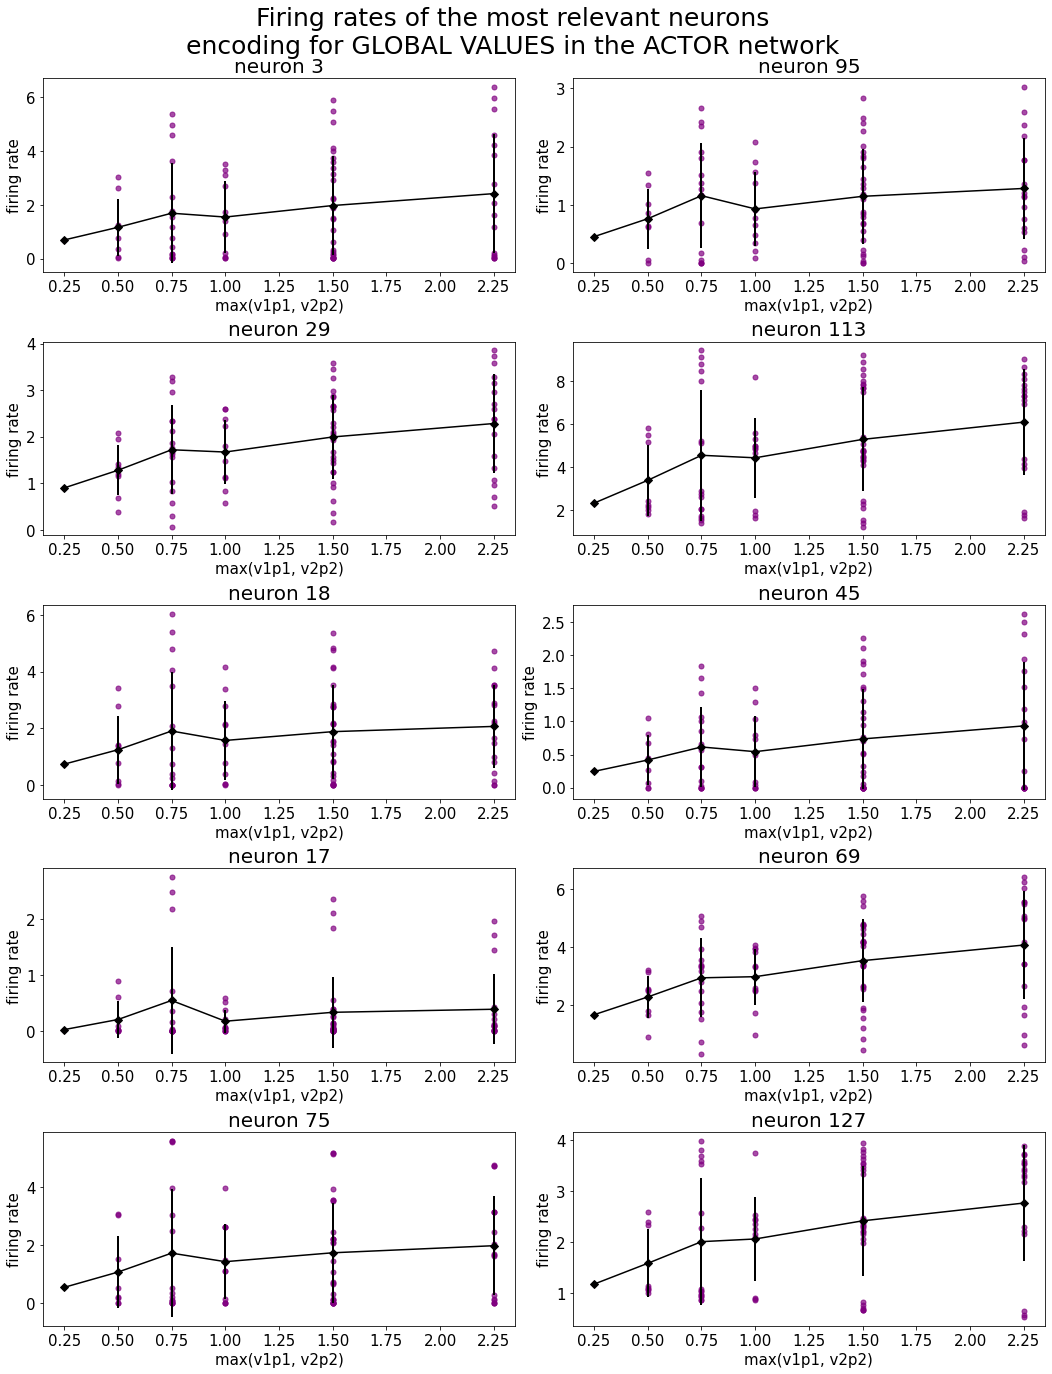

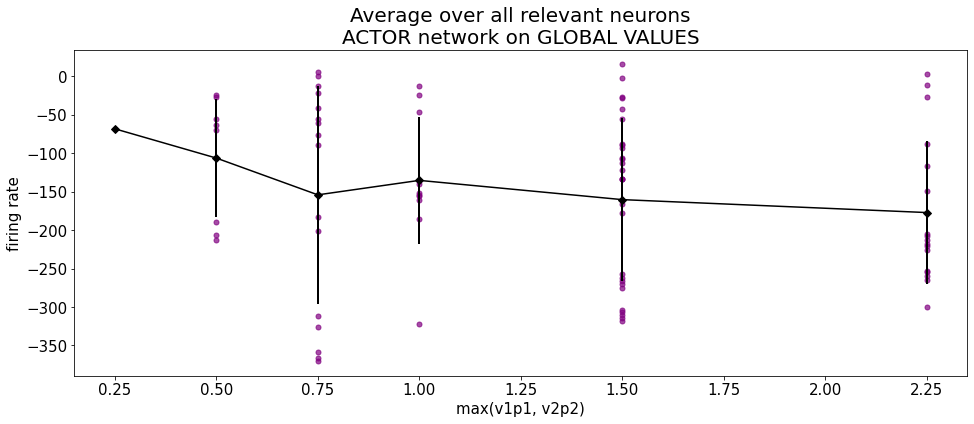

In [19]:
importlib.reload(tun)

#relevant_neurons = np.arange(0,128)
#relevant_weights = np.ones(128)

tun.tuning_curves(relevant_neurons, relevant_weights, net["X"], stimuli, net["network"], label["label"])

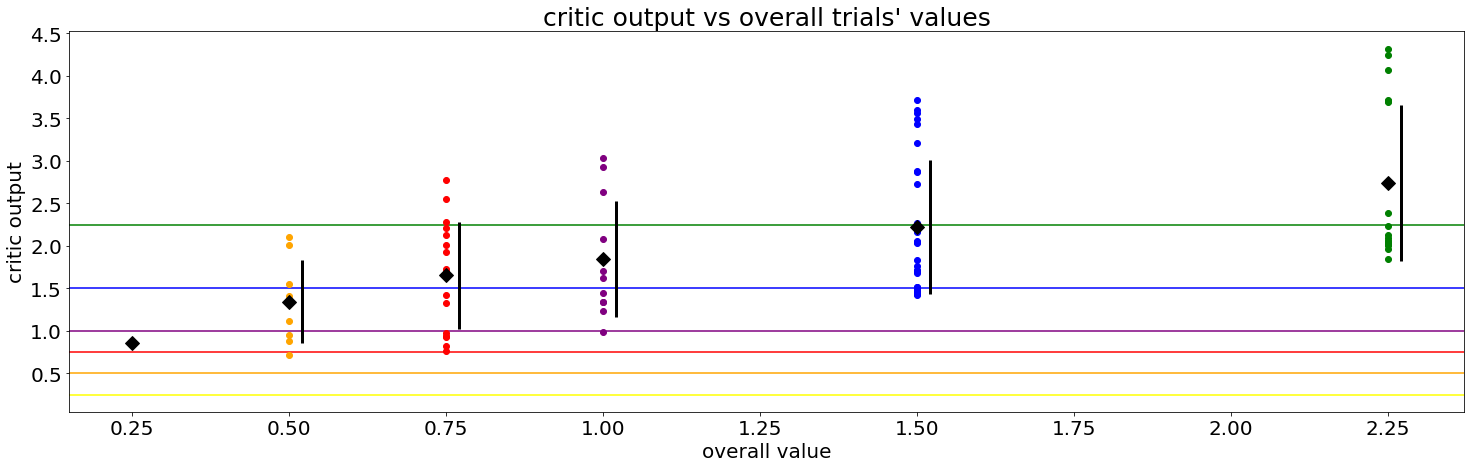

In [30]:
importlib.reload(tun)

tun.critic_tuning_curves(timeav_values, overall_values)

In [8]:
importlib.reload(rln)

v1_array = np.array([3])
p1_array = np.array([0.25])
v2_array = np.array([3])
p2_array = np.array([0.75])

reinforce = rln.REINFORCE(name_load_actor="models/RL_actor_network_good.pt",
                          name_load_critic="models/RL_critic_network_good.pt", 
                          v1s=v1_array, p1s=p1_array, v2s=v2_array, p2s=p2_array)

In [63]:
importlib.reload(rln)

reinforce = rln.REINFORCE(name_load_actor="models/RL_actor_network_good.pt",
                          name_load_critic="models/RL_critic_network_good.pt")

In [9]:
iterations = 200
observations, rewards, actions, log_action_probs, entropies, values,\
trial_begins, errors, frates_col_actor, frates_col_critic,\
time_av_values_col, final_actions, global_values, stimuli= reinforce.experience(iterations)
print(len(errors), errors+1)

iteration 100
iteration 200
0 []


In [ ]:
obs = np.asarray(observations).T
length = 0
for i in range(20):

    plt.figure(figsize=(25,5))

    start = int(trial_begins[i])
    stop = int(trial_begins[i+1])

    plt.plot(obs[0][start:stop], "-o", label="input_fix", color="gray")
    plt.plot(obs[1][start:stop], "-o", label="value_right", color="maroon", alpha=0.9)
    plt.plot(obs[2][start:stop], "-o", label="prob_right", color="firebrick", alpha=0.9)
    plt.plot(obs[3][start:stop], "-o", label="value_left", color="darkblue", alpha=0.9)
    plt.plot(obs[4][start:stop], "-o", label="prob_left", color="royalblue", alpha=0.9)
    plt.plot(actions[start:stop], "-o", label="actions", color="cyan", alpha=0.9)
    plt.plot(rewards[start:stop], "-o", label="rewards", color="gold", alpha=1)
    #plt.plot(cum_rho[start:stop], "-o", label="cum_rho", color="cyan", alpha=0.5)
    plt.plot(values.clone().detach().numpy()[start:stop], "-o", label="values", color="purple", alpha=0.5)
    #plt.plot(stop-length-2, gt[i], "*", markersize=25, color="orange")
    plt.axhline(0, color="black")
    plt.axhline(obs[1][start+10]*obs[2][start+10], color="salmon", linewidth=3)
    plt.axhline(obs[3][start+10]*obs[4][start+10], color="lightsteelblue", linewidth=3)
    length += len(obs[0][start:stop])

    plt.xlabel("t", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("trial %i" %(i+1), size=20)
    plt.
    if actions[start:stop][-2] == 1:
        plt.text(len(actions[start:stop])-3, 1.1, 'R_red', style='italic', fontsize=20)
    elif actions[start:stop][-2] == 2:
        plt.text(len(actions[start:stop])-3, 2.1, 'L_blue', style='italic', fontsize=20)
    plt.legend(fontsize=15, loc="upper left");

In [47]:
importlib.reload(tun)

tun.neurons_population(frates_actor, frates_critic, label["Y"], label["label"])

In [48]:
import json
import numpy as np
with open("neurons_population/"+label["label"]+"/neurons_population_actor.json", 'r') as json_file:
    data_actor = json.load(json_file)

averages_actor = np.array(data_actor["averages"])
stds_actor = np.array(data_actor["stds"])
dcs_actor = np.array(data_actor["dcs"])
dcs_actor = np.sort(dcs_actor)
#print(dcs_actor.shape)
#z = np.zeros((1,128))
#print(z.shape)
#z[0, :]=dcs_actor
#print(z)

import json
import numpy as np
with open("neurons_population/"+label["label"]+"/neurons_population_critic.json", 'r') as json_file:
    data_critic = json.load(json_file)

averages_critic = np.array(data_critic["averages"])
stds_critic = np.array(data_critic["stds"])
dcs_critic = np.array(data_critic["dcs"])
dcs_final = np.array(data_critic["dcs_final"])

dcs_final = np.sort(dcs_final, axis=0)

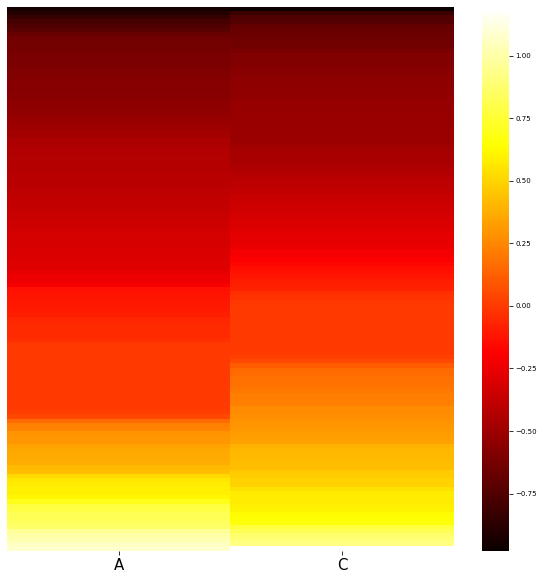

In [56]:
plt.figure(figsize=(10, 10))
sbn.heatmap(dcs_final, cmap="hot", xticklabels=("A", "C"))
plt.xticks(fontsize=15)
plt.yticks([]);